# Predicting Death in MIMIC3

## Data Loading

In [1]:
from numpy.random import seed
seed(2)

import os
import errno
import pickle
import sys
import pandas as pd
import numpy as np
from random import randint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_fscore_support, classification_report
import pydotplus

In [2]:
# Disable GPU (doesn't work for LSTMs)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import keras
from keras.models import Model, Input, load_model, Sequential
from keras.layers import Masking, Flatten, Embedding, Dense, LSTM, TimeDistributed, Reshape, multiply, Permute, Lambda
from keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import plot_model, model_to_dot

Using TensorFlow backend.


In [4]:
# for pretty printing table
pandas_table = pd.option_context('display.max_rows', None, 'display.max_columns', None)
# increased font size for thesis plots
plt.rcParams.update({'font.size': 15})
# set a good figure size for the paper
figsize = (13,7)
set_figsize = lambda: plt.figure(figsize=(13,7))
savefig = lambda x: plt.savefig(os.path.join('figures', x), bbox_inches = "tight")

In [5]:
df = pd.read_csv(os.path.join('../mimic/data_processed', 'mimic_dataset_incomplete.csv'))

In [6]:
def df_split(df, ratio=0.2):
    '''
    Given dataframe, split 20% of patients into a separate test dataframe.
    Return df_train, df_test
    '''
    num_hadms = len(df['HADM_ID'].unique())
    split = int(ratio * num_hadms)
    hadms = df['HADM_ID'].unique()[:split]
    
    return df[~df.HADM_ID.isin(hadms)], df[df.HADM_ID.isin(hadms)]

df_train, df_test = df_split(df)

In [7]:
# sanity check
df_test['HADM_ID'].isin(df_train['HADM_ID']).value_counts()

False    2787
Name: HADM_ID, dtype: int64

In [8]:
df_test['HADM_ID'].unique().shape

(574,)

In [9]:
df_train['HADM_ID'].isin(df_test['HADM_ID']).value_counts()

False    12310
Name: HADM_ID, dtype: int64

In [10]:
df_train['HADM_ID'].unique().shape

(2296,)

In [11]:
X_cols = [
    "Creatinine", "HCO3", "HR", "Haemoglobin", "Platelet_count",
    "Potassium", "RR", "Sodium", "AGE", "GENDER",
    'Chronic Kidney Disease', 'Obesity', 'Heart disease', 'Asthma', #comorbidities
    'Weight_kg', 'SaO2',
]

In [12]:
def create_tensors(df, maxshape=(0,0)):
    '''
    Split dataframe into X and Y tensors.

    Return X, Y
    '''
    hadms = df['HADM_ID'].unique()
    
    lst = []
    lst_y = []
    
    for hadm in hadms:
        point = df[df.HADM_ID == hadm][X_cols]
        maxshape = max(maxshape, point.values.shape)
        
        # for now, try with data only 48hours prior
#         if len(point.values) > 2:
#             point = point[:-2]
            
        lst.append(point.values)
        lst_y.append(df[df.HADM_ID == hadm]['DEATH'].iloc[0])
    
    # pad to max shape to create tensor
    ret = np.zeros((len(lst), *maxshape))
    
    ret_y = np.array(lst_y)
    
    for index, l in enumerate(lst):
        x, y = min(maxshape[0], l.shape[0]), l.shape[1]

        ret[index, :x, :y] = l[:x, :y]

    return lst, ret, ret_y

lst_train, X_train, Y_train = create_tensors(df_train)
lst_test, X_test, Y_test = create_tensors(df_test)

In [13]:
X_train.shape

(2296, 62, 16)

## Dataset

### Histogram of Days

Don't cut to 14 days - want last day data before death for now

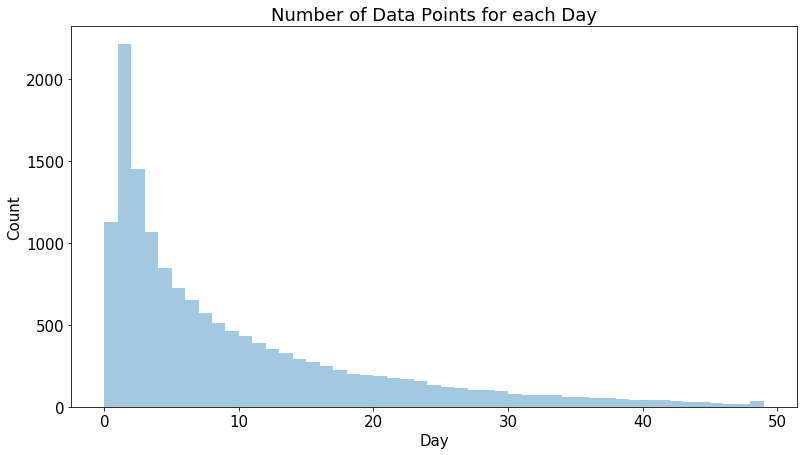

In [14]:
set_figsize()
fig = sns.distplot(df[df.Day < 50]['Day'], bins=range(50), kde=False)
title = 'Number of Data Points for each Day'
plt.title(title)
plt.ylabel('Count')
savefig(title)

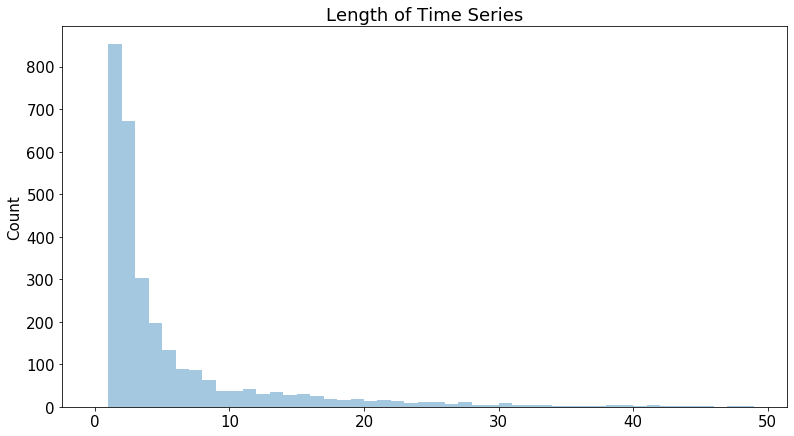

In [15]:
set_figsize()
fig = sns.distplot([len(x) for x in lst_train + lst_test if len(x) <= 50], bins=range(50), kde=False)
title = 'Length of Time Series'
plt.title(title)
plt.ylabel('Count')
savefig(title)

In [16]:
# summary statistics
df['Day'].describe()

count    15097.000000
mean        10.473935
std         13.514752
min          0.000000
25%          2.000000
50%          6.000000
75%         14.000000
max        131.000000
Name: Day, dtype: float64

In [17]:
df[df['DEATH'] == 1]['Day'].describe()

count    6188.000000
mean       12.059308
std        16.175273
min         0.000000
25%         3.000000
50%         7.000000
75%        15.000000
max       131.000000
Name: Day, dtype: float64

In [18]:
df[df['DEATH'] == 0]['Day'].describe()

count    8909.000000
mean        9.372769
std        11.173525
min         0.000000
25%         1.000000
50%         5.000000
75%        14.000000
max        76.000000
Name: Day, dtype: float64

In [19]:
# number of patients who died
df.groupby('HADM_ID').first()['DEATH'].value_counts()

0    1977
1     893
Name: DEATH, dtype: int64

In [20]:
1 - sum(np.append(Y_train, Y_test)) / len(np.append(Y_train, Y_test))

0.6888501742160279

In [21]:
# class weights
class_weight = {0: 1, 1: 2}

### Histogram of Outcomes for Each Feature
We want to see the distributions for each different numeric feature. This is best done as a histogram. You can see all of these histograms below.

HCO3, Age and Heart Rate appear to be the most separable. 

In [22]:
def plot_feature(col):
    died = []
    discharged = []

    for index, point in enumerate(lst_train + lst_test):        
        if np.append(Y_train, Y_test)[index]:
            died.append(point[0, X_cols.index(col)])
        else:
            discharged.append(point[0, X_cols.index(col)])

    minimum = min(*died,*discharged)
    maximum = max(*died,*discharged)
    
    if minimum == 0 and maximum == 1:
        return
    
    bins = np.linspace(minimum, maximum, num=20)

    set_figsize()
    sns.distplot(discharged, kde=False, bins=bins, label="Discharged")
    fig = sns.distplot(died, kde=False, bins=bins, label="Died")
    title = f'Histogram for {col.title()}'
    plt.title(title)
    plt.ylabel('Count')
    plt.xlabel(str(col.title()))
    plt.legend()
    savefig(title)   
    plt.show(fig)

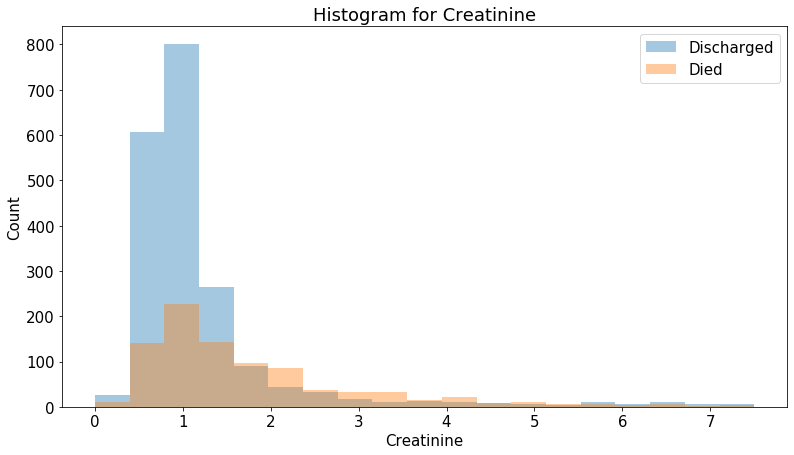

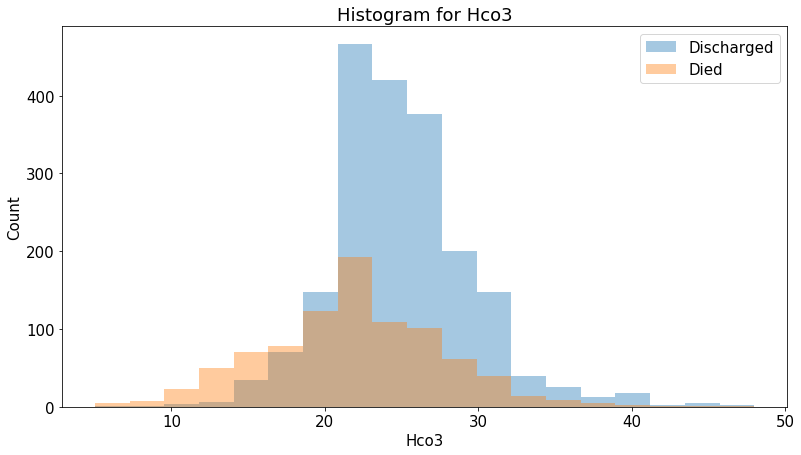

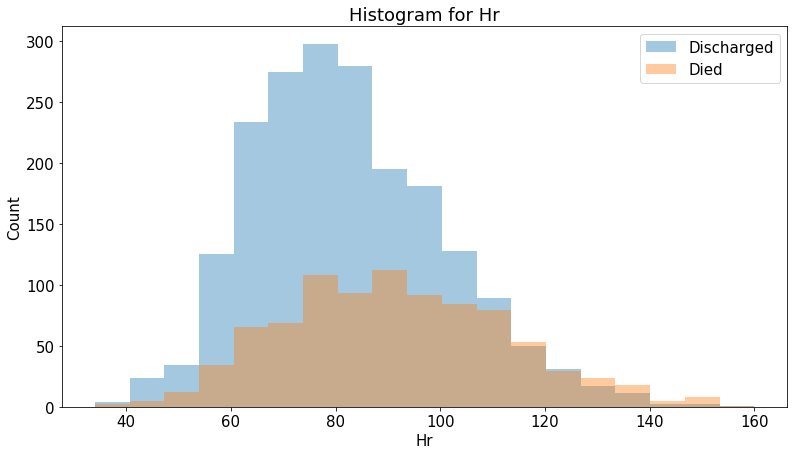

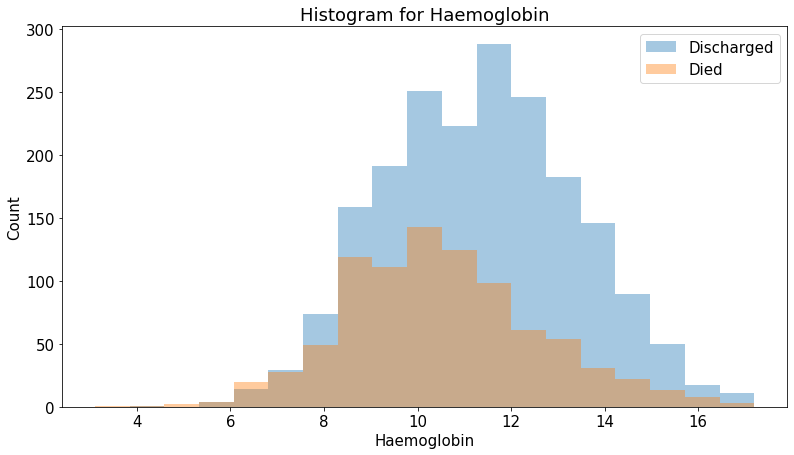

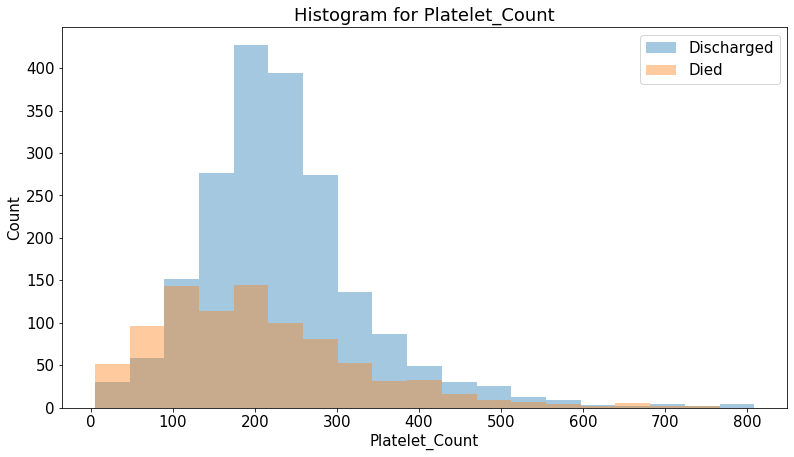

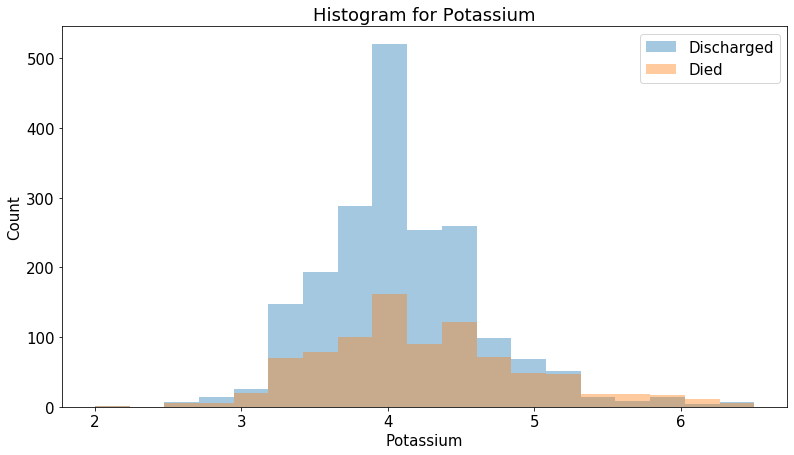

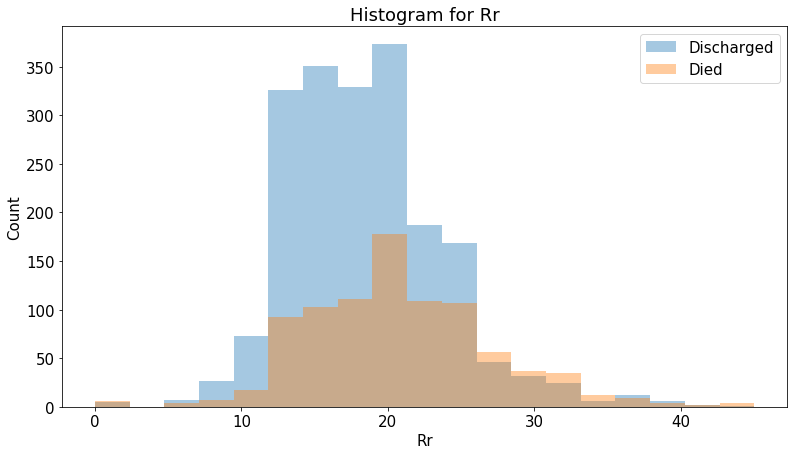

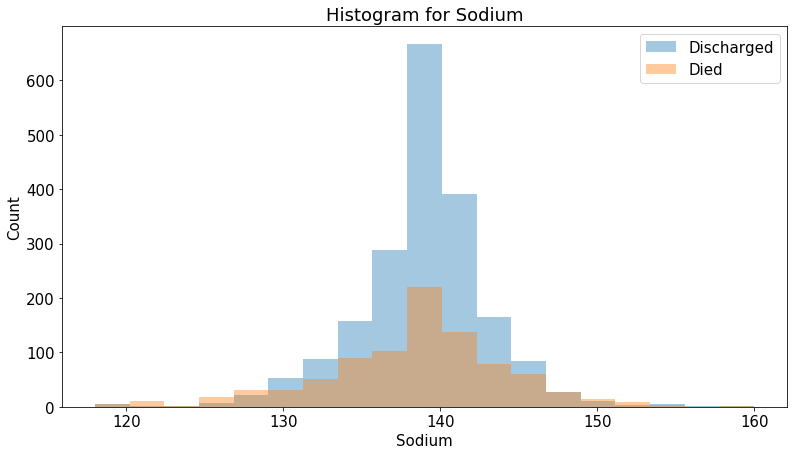

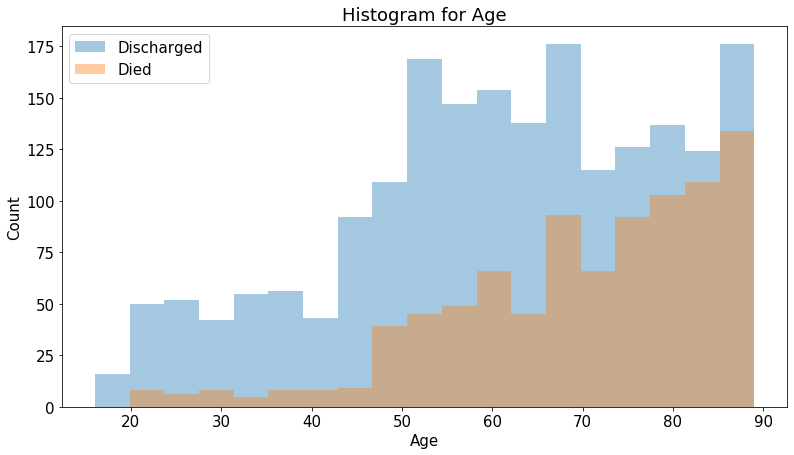

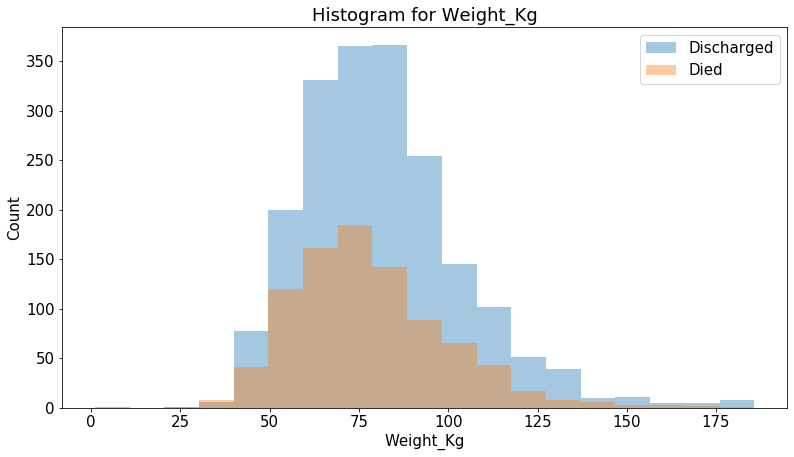

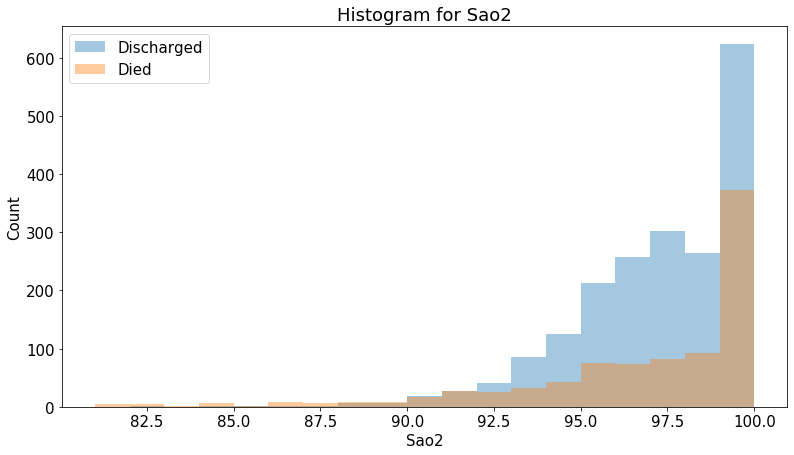

In [23]:
for col in X_cols:
    plot_feature(col)

### Histogram of Outcomes for each day

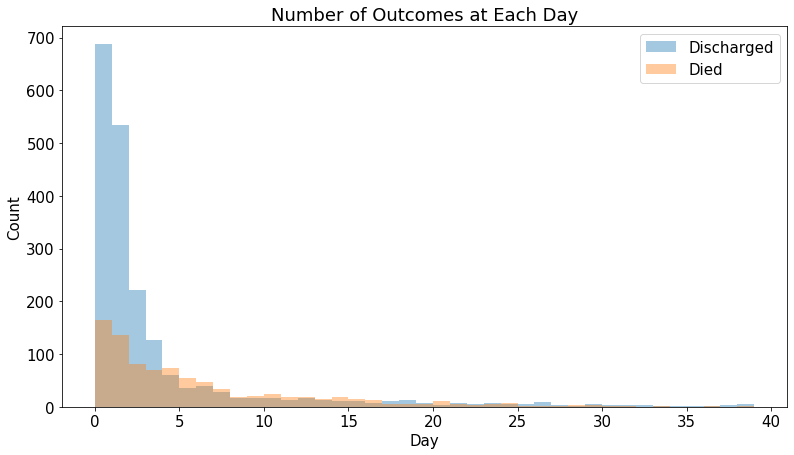

In [24]:
died = []
discharged = []

for index, point in enumerate(lst_train + lst_test):
    if len(point) - 1 > 40:
        continue
        
    if np.append(Y_train, Y_test)[index]:
        died.append(len(point) - 1)
    else:
        discharged.append(len(point) - 1)
    
set_figsize()
sns.distplot(discharged, kde=False, bins=range(40), label="Discharged")
fig = sns.distplot(died, kde=False, bins=range(40), label="Died")
title = 'Number of Outcomes at Each Day'
plt.title('Number of Outcomes at Each Day')
plt.ylabel('Count')
plt.xlabel('Day')
plt.legend()
savefig(title)

### Correlation matrix

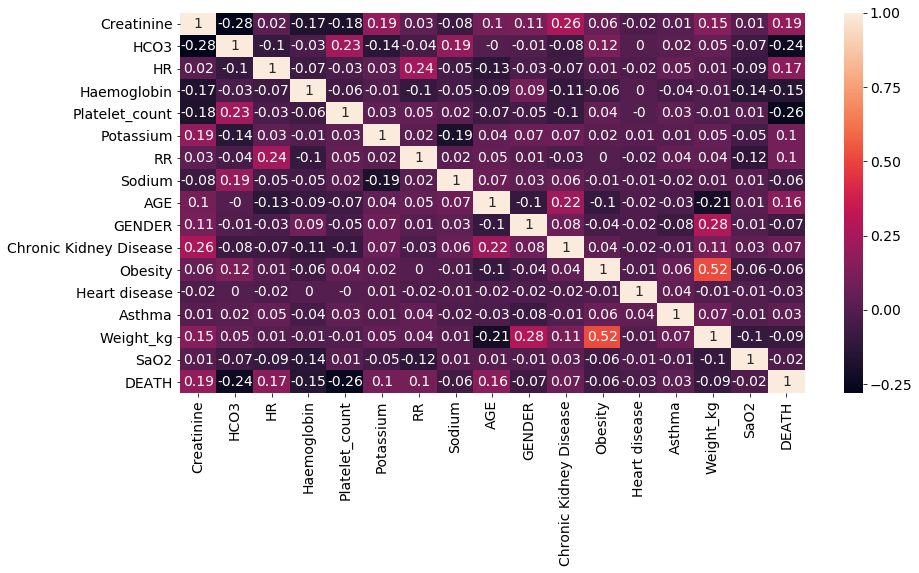

In [25]:
corrMatrix = df[X_cols + ['DEATH']].corr()
corrMatrix = round(corrMatrix, 2)

# set_figsize()
plt.figure(figsize=(14,7))
plt.rcParams.update({'font.size': 14})

sns.heatmap(corrMatrix, annot=True)

# fix matplotlib bug https://github.com/mwaskom/seaborn/issues/1773
b, t = plt.ylim()
plt.ylim(b + 0.5, t - 0.5)
# plt.gcf().subplots_adjust(bottom=0.35, left=0.2)
savefig('Correlation Matrix')

### Create Model

Why 128 units?
Hypermarater search?
TODO

In [26]:
# units - dimensionality of output space from LSTM
lstm_units = 128

In [27]:
input_layer = Input(shape=(None, len(X_cols)), name='timeseries') 

# set states going into this LSTM application
# in order to use SHAP, need to pass on state
feedin_previous_output = Input(shape=(lstm_units), name='previous_output') 
feedin_cell_state = Input(shape=(lstm_units), name='cell_state') 

x = Masking(mask_value=0)(input_layer)
x = LSTM(lstm_units, return_state=True)(x, initial_state=[feedin_previous_output, feedin_cell_state])

# get output from LSTM
output = Lambda(lambda x: x[0], name='get_model_output')(x)
# output = Dense(128)(output)
output = Dense(1, activation='sigmoid')(output) # binary output

# as well as the model output, we want the hidden state output and the cell
# state for later. 
# See https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/
lstm_output = Lambda(lambda x: x[0], name='get_lstm_output')(x)
cell_state = Lambda(lambda x: x[2], name='get_cell_state')(x)

model = Model(inputs=[input_layer, feedin_previous_output, feedin_cell_state],
              outputs=[output, lstm_output, cell_state])

In [28]:
model.summary()

optimizer = Adam(lr=0.0005, epsilon=1e-08)
# only optimize output from dense layer
model.compile(optimizer, loss=['binary_crossentropy', None, None], metrics=['acc'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
timeseries (InputLayer)         [(None, None, 16)]   0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, None, 16)     0           timeseries[0][0]                 
__________________________________________________________________________________________________
previous_output (InputLayer)    [(None, 128)]        0                                            
__________________________________________________________________________________________________
cell_state (InputLayer)         [(None, 128)]        0                                            
______________________________________________________________________________________________

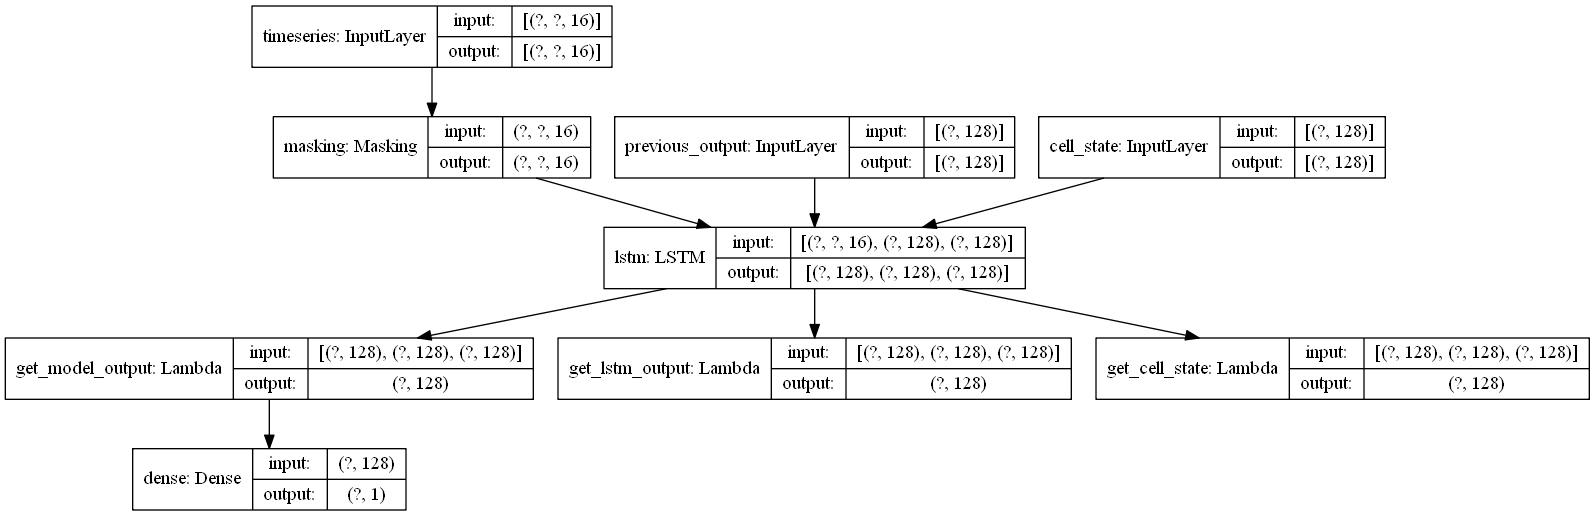

In [29]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='figures/BIG model.png')

In [30]:
def model_predict(x, h=None, c=None, state=False):
    """Wrapper function for running model predictions. 
    
    h: Input to the model, corresponds with `feedin_previous_output`.
        Set to None for default initialization
        
    c: Input to the model, corresponds with `feedin_cell_state`.
        Set to None for default initialization
        
    state: If True, return the state from the model. Otherwise, just return output.
    
    Returns: model output
    """
    
    if h is None:
        h = np.zeros((len(x), lstm_units))
        
    if c is None:
        c = np.zeros((len(x), lstm_units))

    if state:
        return model.predict([x, h, c])
    return model.predict([x, h, c])[0]

def model_evaluate(x, y):
    """Wrapper function to evaluate model accuracy on x and y. Returns accuracy."""
    
    return model.evaluate(x=[x, np.zeros((len(x), lstm_units)), np.zeros((len(x), lstm_units))],
                          y=y, verbose=False)[2]

In [30]:
model.fit(x=[X_train, np.zeros((len(X_train), 128)), np.zeros((len(X_train), 128))],
          y=Y_train, class_weight=class_weight, epochs=70)

Epoch 1/70
72/72 [==============================] - 1s 9ms/step - loss: 0.8127 - dense_loss: 0.8127 - dense_acc: 0.7247 - get_lstm_output_acc: 0.0000e+00 - get_cell_state_acc: 0.0483
Epoch 2/70
72/72 [==============================] - 1s 8ms/step - loss: 0.7184 - dense_loss: 0.7184 - dense_acc: 0.7648 - get_lstm_output_acc: 4.3554e-04 - get_cell_state_acc: 0.2326
Epoch 3/70
72/72 [==============================] - 1s 8ms/step - loss: 0.6860 - dense_loss: 0.6860 - dense_acc: 0.7744 - get_lstm_output_acc: 0.0000e+00 - get_cell_state_acc: 0.4521
Epoch 4/70
72/72 [==============================] - 1s 8ms/step - loss: 0.6713 - dense_loss: 0.6713 - dense_acc: 0.7753 - get_lstm_output_acc: 0.0000e+00 - get_cell_state_acc: 0.4395
Epoch 5/70
72/72 [==============================] - 1s 8ms/step - loss: 0.6552 - dense_loss: 0.6552 - dense_acc: 0.7875 - get_lstm_output_acc: 0.0000e+00 - get_cell_state_acc: 0.4321
Epoch 6/70
72/72 [==============================] - 1s 8ms/step - loss: 0.6447 - dens

In [59]:
model_evaluate(X_train, Y_train)

0.8597561120986938

In [60]:
model_evaluate(X_test, Y_test)

0.8675957918167114

In [ ]:
saved_models.append((model_evaluate(X_train, Y_train), model_evaluate(X_test, Y_test), model))

In [ ]:
%%javascript
// Retrain model
Jupyter.notebook.execute_cells(Array(9).fill(35).map((x, y) => x + y))

<IPython.core.display.Javascript object>

In [36]:
saved_models = []

In [35]:
saved_models_df = pd.DataFrame(np.array([(x[0], x[1]) for x in saved_models]), columns=['train', 'test'])

In [36]:
saved_models_df

train      test
0    0.863240  0.871080
1    0.847125  0.832753
2    0.850174  0.837979
3    0.831446  0.829268
4    0.856707  0.851916
..        ...       ...
124  0.844948  0.832753
125  0.837979  0.843206
126  0.860627  0.865854
127  0.850174  0.846690
128  0.861063  0.848432

[129 rows x 2 columns]

In [37]:
saved_models_df.describe()

train        test
count  129.000000  129.000000
mean     0.849165    0.849675
std      0.013854    0.016654
min      0.787021    0.789199
25%      0.841463    0.837979
50%      0.850610    0.850174
75%      0.858885    0.862369
max      0.870209    0.888502

In [38]:
no_overfit = saved_models_df[
    saved_models_df['train'] < saved_models_df['test'] + .02].rename(
    lambda x: x + '_no_overfit', axis='columns')

In [39]:
no_overfit.describe()

train_no_overfit  test_no_overfit
count        128.000000       128.000000
mean           0.849245         0.849956
std            0.013878         0.016407
min            0.787021         0.789199
25%            0.842117         0.839286
50%            0.850828         0.851045
75%            0.858885         0.862805
max            0.870209         0.888502

In [1247]:
saved_models_df['train_no_overfit'] = no_overfit['train_no_overfit']
saved_models_df['test_no_overfit'] = no_overfit['test_no_overfit']

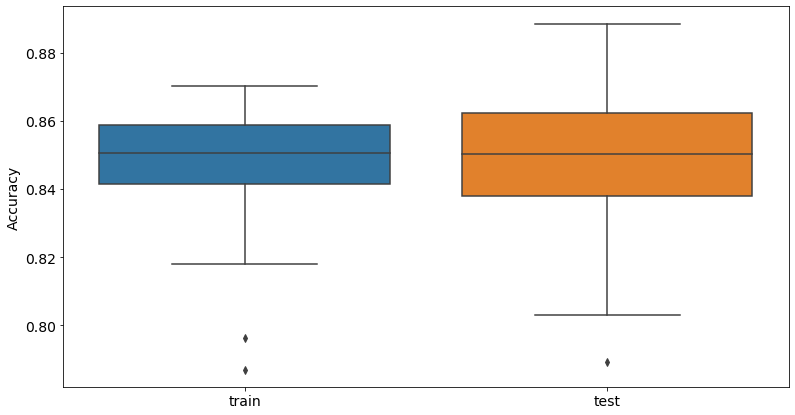

In [54]:
set_figsize()
sns.boxplot(data=saved_models_df)
plt.ylabel('Accuracy')
title = 'LSTM instability no hidden'
savefig(title)

In [41]:
saved_models_df.values

array([[0.86324042, 0.87108016],
       [0.84712541, 0.83275259],
       [0.85017419, 0.83797908],
       [0.83144599, 0.82926828],
       [0.85670733, 0.85191637],
       [0.85714287, 0.86411148],
       [0.84015679, 0.82752615],
       [0.85452962, 0.86933798],
       [0.84799653, 0.84668988],
       [0.85278744, 0.86585367],
       [0.86149824, 0.86933798],
       [0.85365856, 0.84320557],
       [0.85278744, 0.85888499],
       [0.8436411 , 0.84494776],
       [0.86324042, 0.87630659],
       [0.85060978, 0.85365856],
       [0.8388502 , 0.84494776],
       [0.8488676 , 0.85017419],
       [0.81925088, 0.83101046],
       [0.85844946, 0.86062717],
       [0.8436411 , 0.84146339],
       [0.8349303 , 0.85017419],
       [0.86062717, 0.86411148],
       [0.85714287, 0.85888499],
       [0.8262195 , 0.82404178],
       [0.84015679, 0.83275259],
       [0.84102786, 0.83797908],
       [0.84146339, 0.85540068],
       [0.85104531, 0.85017419],
       [0.84451222, 0.84146339],
       [0.

In [74]:
# save model, remember to set a name
model_name = os.path.join('saved_models', 'BinaryDeath_868_final')
model.save(model_name, overwrite=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_models\BinaryDeath_868_final\assets


In [31]:
# load model
model_name = os.path.join('saved_models', 'BinaryDeath_868_final')
# model_name = os.path.join('saved_models', 'BinaryDeath_arterial_865')
model = keras.models.load_model(model_name)

In [32]:
# AUC
res = model_predict(x=X_test)[:,0]
argsort = np.argsort(res)

roc_auc_score(Y_test[argsort], res[argsort])

0.9090982653856905

In [33]:
print(classification_report(Y_test[argsort], np.rint(res[argsort]).astype(int)))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91       407
           1       0.84      0.67      0.75       167

    accuracy                           0.87       574
   macro avg       0.86      0.81      0.83       574
weighted avg       0.87      0.87      0.86       574



how good is it?:
compare random forest with only admission data
can also do LSTM for this

## Missclassified results

In [34]:
argsort = np.argsort(Y_test)
Y_test[argsort[::-1]]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [35]:
preds = model_predict(X_test)
np.rint(preds).astype(int)[:,0][argsort[::-1]]

array([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

# Plot accuracy vs increasing sequence length (from 0)

The model was trained to predict if the patient died, so compare this to the percentage of patients who died in the dataset

In [36]:
def get_discharge_rate(x):
    """Get the percentage of patients who were discharged with only x days of data from admission"""
    died = 0
    total = 0

    for index, seq in enumerate(lst_test):
        if len(seq) <= x:
            died += Y_test[index]
            total += 1

    return 1 - died / total

In [37]:
def get_percent_complete_data(x):
    """Get the percentage of time series that are complete with only x days of data from admission"""
    complete = 0
    total = 0

    for index, seq in enumerate(lst_test):
        if len(seq) <= x:
            complete += 1
        total += 1

    return complete / total

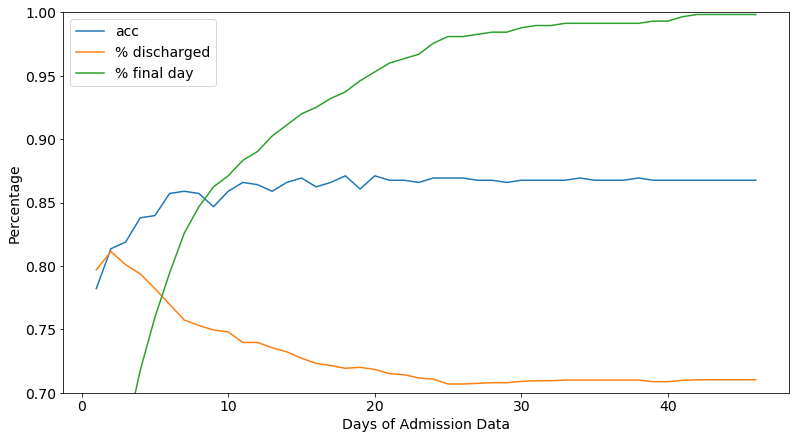

In [38]:
maxseqlen_test = max(len(lst) for lst in lst_test)
x = list(range(1,maxseqlen_test))
y = [model_evaluate(X_test[:,:a,:], Y_test) for a in x]

set_figsize()
sns.lineplot(x=x, y=y, label='acc')
sns.lineplot(x=x, y=[get_discharge_rate(a) for a in x], label='% discharged')
sns.lineplot(x=x, y=[get_percent_complete_data(a) for a in x], label='% final day')
plt.ylabel('Percentage')
plt.xlabel('Days of Admission Data')
plt.legend()
plt.ylim(0.7, 1)
title = 'LSTM Admission Data'
savefig(title)

# Plot accuracy vs increasing sequence length (from end)
Is the model using anything more than the previous days data to predict death? 
If the accuracy increases when using more data from the end we can assume so.

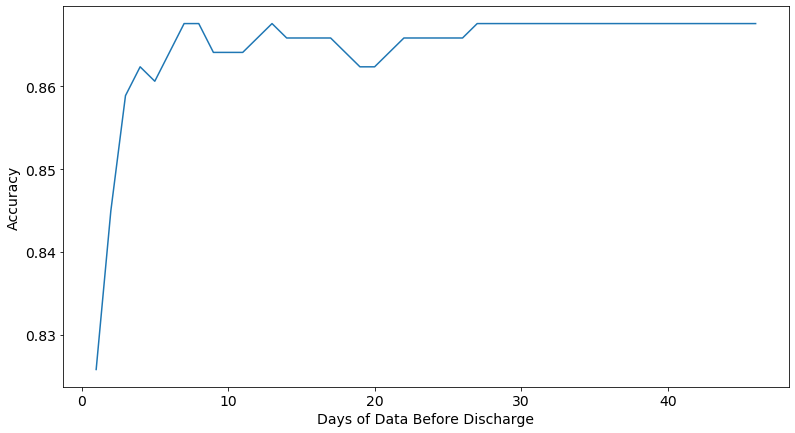

In [39]:
x = list(range(1,maxseqlen_test))
y = []

arr = np.zeros(X_test.shape)

for length in x:
    for index, point in enumerate(lst_test):
        r = np.array(point[::-1][:length][::-1])
        arr[index, :r.shape[0], :X_test.shape[2]] = r

    y.append(model_evaluate(arr, Y_test))
    
set_figsize()
fig = sns.lineplot(x=x, y=y)
title = 'LSTM Accuracy Using Number of Days from Discharge or Death'
plt.ylabel('Accuracy')
plt.xlabel('Days of Data Before Discharge')
savefig(title)

In [40]:
y[:10]

[0.8257839679718018,
 0.8449477553367615,
 0.8588849902153015,
 0.8623693585395813,
 0.8606271743774414,
 0.8641114830970764,
 0.8675957918167114,
 0.8675957918167114,
 0.8641114830970764,
 0.8641114830970764]

# Plot accuracy vs decreasing sequence length (from end)
E.g. accuracy without last 1,2,3,... days

Baseline represents accuracy from always predicting discharged

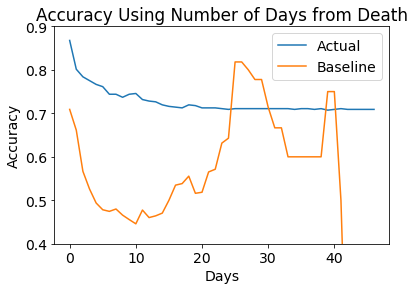

In [41]:
x = list(range(maxseqlen_test))
y = []
z = []

for length in x:
    arr = np.zeros(X_test.shape)
    discharged, total = 0, 0
    
    for index, point in enumerate(lst_test):
        r = point
        if len(point) > length:
            if length > 0:
                r = r[:-length]
                
            if Y_test[index] == 0:
                discharged += 1
            total += 1
            
            arr[index, :r.shape[0], :X_test.shape[2]] = r

    y.append(model_evaluate(arr, Y_test))
    z.append(discharged / total)
    
fig = sns.lineplot(x=x, y=y, label='Actual')
fig = sns.lineplot(x=x, y=z, label='Baseline')
plt.title('Accuracy Using Number of Days from Death')
plt.ylabel('Accuracy')
plt.xlabel('Days')
plt.ylim(0.4, 0.9)
plt.show(fig)

# Misclassified stats

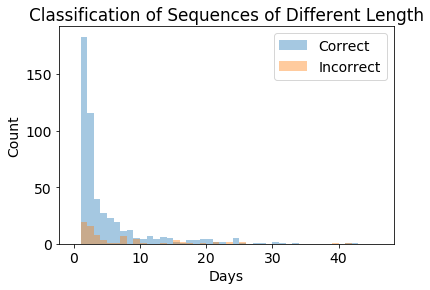

In [42]:
correct = []
incorrect = []

for index in range(len(lst_test)):
    result = model_predict(np.array([lst_test[index]]))[0][0]

    if Y_test[index] == round(result):
        correct.append(len(lst_test[index]))
    else:
        incorrect.append(len(lst_test[index]))

sns.distplot(correct, kde=False, bins=range(max(*correct, *incorrect)), label="Correct")
fig = sns.distplot(incorrect, kde=False, bins=range(max(*correct, *incorrect)), label="Incorrect")
plt.legend()
plt.title('Classification of Sequences of Different Length')
plt.ylabel('Count')
plt.xlabel('Days')
plt.legend()
plt.show(fig)

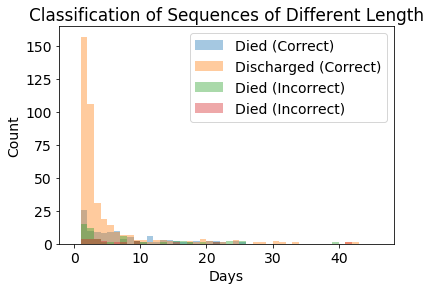

In [43]:
correct = {'Died':[], 'Discharged':[]}
incorrect = {'Died':[], 'Discharged':[]}

for index in range(len(lst_test)):
    result = model_predict(np.array([lst_test[index]]))[0][0]

    if Y_test[index] == round(result):
        if Y_test[index] == 0:
            correct['Discharged'].append(len(lst_test[index]))
        else:
            correct['Died'].append(len(lst_test[index]))
    else:
        if Y_test[index] == 0:
            incorrect['Discharged'].append(len(lst_test[index]))
        else:
            incorrect['Died'].append(len(lst_test[index]))
            
bins = range(max([y for x in list(correct.values()) + list(incorrect.values()) for y in x]))
            
sns.distplot(correct['Died'], kde=False, bins=bins, label="Died (Correct)")
sns.distplot(correct['Discharged'], kde=False, bins=bins, label="Discharged (Correct)")
sns.distplot(incorrect['Died'], kde=False, bins=bins, label="Died (Incorrect)")
fig = sns.distplot(incorrect['Discharged'], kde=False, bins=bins, label="Died (Incorrect)")
plt.legend()
plt.title('Classification of Sequences of Different Length')
plt.ylabel('Count')
plt.xlabel('Days')
plt.legend()
plt.show(fig)

# SHAP

Import a local version of shap in order to change a default setting for force plots. This is optional.

In [44]:
sys.path.append(os.path.join('../..', 'shap'))
import shap as shap

shap.initjs()

In [45]:
def predict(X, **kwargs):
    X = X.reshape((-1,1,len(X_cols)))
    return model_predict(X).flatten()

In [46]:
all_data_summary = shap.kmeans(df_test[X_cols], 10)

In [47]:
input_data = df_test[X_cols]

#### Compare summary dataset to actual dataset

In [48]:
pd.DataFrame(all_data_summary.data, columns=input_data.columns).describe()

Creatinine   HCO3         HR  Haemoglobin  Platelet_count  Potassium  \
count   10.000000  10.00  10.000000    10.000000       10.000000  10.000000   
mean     1.330000  26.00  87.400000     9.950000      321.100000   4.110000   
std      0.352924   2.00   4.325634     0.672062      204.603926   0.073786   
min      0.900000  23.00  81.000000     9.200000       52.000000   4.000000   
25%      1.200000  25.00  85.000000     9.350000      189.750000   4.100000   
50%      1.250000  26.00  86.500000     9.950000      275.500000   4.100000   
75%      1.300000  26.75  90.000000    10.375000      434.000000   4.175000   
max      2.000000  30.00  95.000000    11.100000      710.000000   4.200000   

              RR      Sodium        AGE     GENDER  Chronic Kidney Disease  \
count  10.000000   10.000000  10.000000  10.000000                    10.0   
mean   20.800000  139.500000  62.800000   0.800000                     0.0   
std     1.135292    0.849837   6.106463   0.421637                     0.0   
min    19.000000  138.000000  55.000000   0.000000                     0.0   
25%    20.000000  139.000000  57.000000   1.000000                     0.0   
50%    21.000000  139.500000  65.500000   1.000000                     0.0   
75%    21.000000  140.000000  67.500000   1.000000                     0.0   
max    23.000000  141.000000  71.000000   1.000000                     0.0   

       Obesity  Heart disease  Asthma   Weight_kg       SaO2  
count     10.0           10.0    10.0   10.000000  10.000000  
mean       0.0            0.0     0.0   85.260000  96.900000  
std        0.0            0.0     0.0   14.467988   0.316228  
min        0.0            0.0     0.0   74.500000  96.000000  
25%        0.0            0.0     0.0   79.225000  97.000000  
50%        0.0            0.0     0.0   81.750000  97.000000  
75%        0.0            0.0     0.0   83.525000  97.000000  
max        0.0            0.0     0.0  125.000000  97.000000

In [49]:
input_data.describe()

Creatinine         HCO3           HR  Haemoglobin  Platelet_count  \
count  2787.000000  2787.000000  2787.000000  2787.000000     2787.000000   
mean      1.442232    25.387155    86.662720    10.083818      240.485109   
std       1.206696     5.879358    18.437774     1.913747      146.526600   
min       0.100000     5.000000    34.000000     3.100000        5.000000   
25%       0.700000    22.000000    74.000000     8.600000      133.000000   
50%       1.000000    25.000000    85.000000     9.800000      221.000000   
75%       1.700000    29.000000    99.000000    11.300000      317.000000   
max       7.400000    47.000000   162.000000    17.100000      815.000000   

         Potassium           RR       Sodium          AGE       GENDER  \
count  2787.000000  2787.000000  2787.000000  2787.000000  2787.000000   
mean      4.096197    20.495515   139.197704    65.414424     0.553283   
std       0.557163     6.075402     5.286754    16.262588     0.497242   
min       2.500000     0.000000   118.000000    17.000000     0.000000   
25%       3.700000    16.000000   136.000000    54.000000     0.000000   
50%       4.000000    20.000000   139.000000    67.000000     1.000000   
75%       4.400000    24.000000   142.000000    80.000000     1.000000   
max       6.500000    45.000000   158.000000    89.000000     1.000000   

       Chronic Kidney Disease      Obesity  Heart disease       Asthma  \
count             2787.000000  2787.000000    2787.000000  2787.000000   
mean                 0.118048     0.091137       0.001076     0.097955   
std                  0.322723     0.287856       0.032797     0.297307   
min                  0.000000     0.000000       0.000000     0.000000   
25%                  0.000000     0.000000       0.000000     0.000000   
50%                  0.000000     0.000000       0.000000     0.000000   
75%                  0.000000     0.000000       0.000000     0.000000   
max                  1.000000     1.000000       1.000000     1.000000   

         Weight_kg         SaO2  
count  2787.000000  2787.000000  
mean     82.062397    96.871188  
std      26.307245     2.923944  
min      32.000000    81.000000  
25%      65.900000    95.000000  
50%      77.200000    97.000000  
75%      93.250000    99.000000  
max     185.700000   100.000000

In [48]:
%%time
explainer = shap.KernelExplainer(predict, all_data_summary)
shap_values = explainer.shap_values(input_data)


Wall time: 36min 53s


In [247]:
# save explanations to save time rerunning everything
try:
    os.makedirs(os.path.join(model_name, 'shap_values'))
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
        
pickle.dump(explainer, open(os.path.join(model_name, 'shap_values', 'explainer.pkl'), "wb"))
pickle.dump(shap_values, open(os.path.join(model_name, 'shap_values', 'shap_values.pkl'), "wb"))

In [50]:
# load explanations
explainer = pickle.load(open(os.path.join(model_name, 'shap_values', 'explainer.pkl'), "rb"))
shap_values = pickle.load(open(os.path.join(model_name, 'shap_values', 'shap_values.pkl'), "rb"))

High SHAP values -> influenced the model towards death. E.g. High age and heart rate is associated with dying.

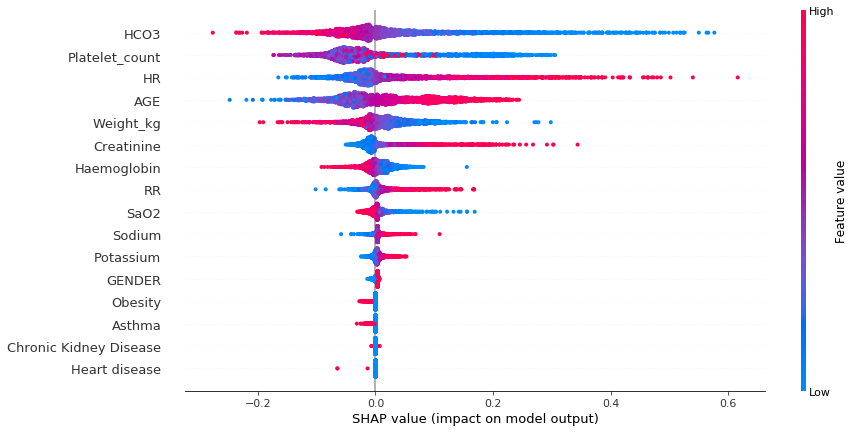

In [51]:
shap.summary_plot(shap_values, input_data, plot_size=figsize, show=False)

title = 'Vanilla SHAP Global'
savefig(title)

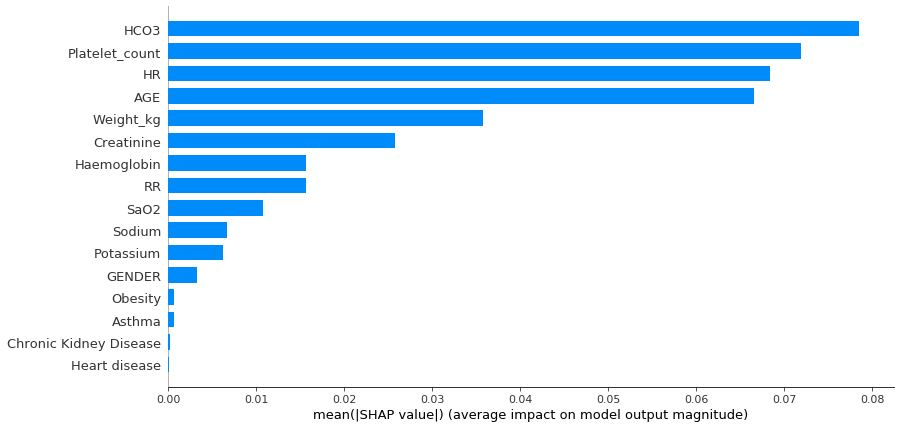

In [56]:
shap.summary_plot(shap_values, input_data, plot_type="bar", plot_size=figsize, show=False)
savefig('Vanilla SHAP Feature Importance')

In [58]:
input_data.shape

(2787, 16)

The below shows a plot of age against the SHAP value. We can see that the age of around 65 has no effect on the model, in this case it is the average value. We also see how a high age always increases death chance, and a low age always decreases. However, this is not always the case. e.g. Heart rate can be too low or too high which will increase the shap value.

Bonus - try changing internaction_index

In [121]:
df.mean()

Creatinine                     1.496145
HCO3                          25.536067
HR                            86.659601
Haemoglobin                    9.982877
Platelet_count               232.999616
Potassium                      4.081155
RR                            20.466318
Sodium                       139.276744
Weight_kg                     83.368583
SaO2                          97.038153
HADM_ID                   150594.118832
DAYS_TO_DISCH                 18.618136
AGE                           65.814533
GENDER                         0.570378
Day                           10.473935
DEATH                          0.409883
Chronic Kidney Disease         0.160893
Obesity                        0.100086
Heart disease                  0.001192
Asthma                         0.084785
dtype: float64

In [56]:
df_test['AGE'].mean()

65.41442411194834

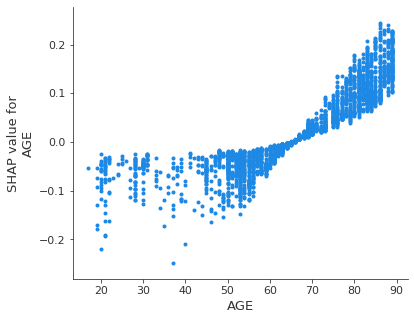

In [95]:
shap.dependence_plot('AGE', shap_values, features=input_data, interaction_index=None)

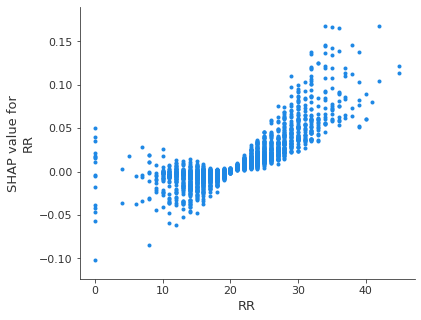

In [58]:
shap.dependence_plot('RR', shap_values, features=input_data, interaction_index=None)

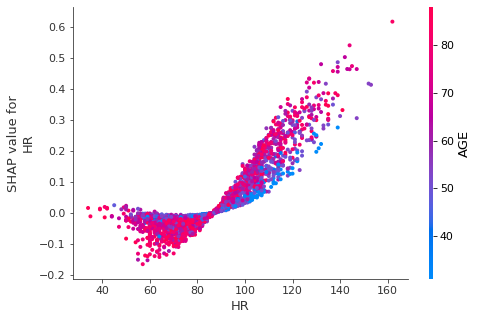

In [59]:
shap.dependence_plot('HR', shap_values, features=input_data, interaction_index='AGE')

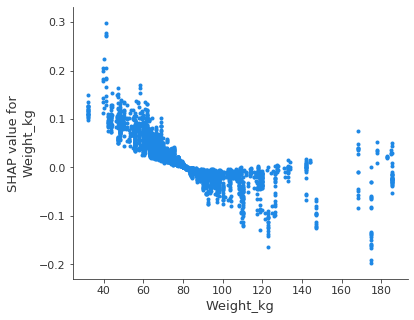

In [60]:
shap.dependence_plot('Weight_kg', shap_values, features=input_data, interaction_index=None)

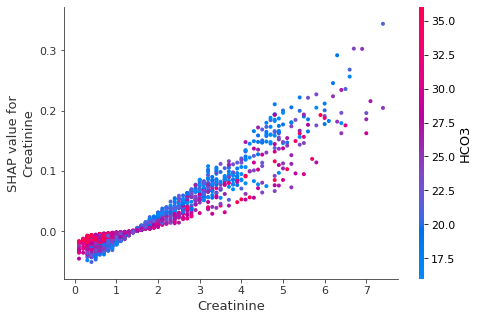

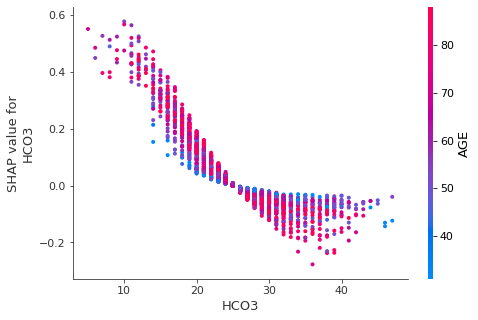

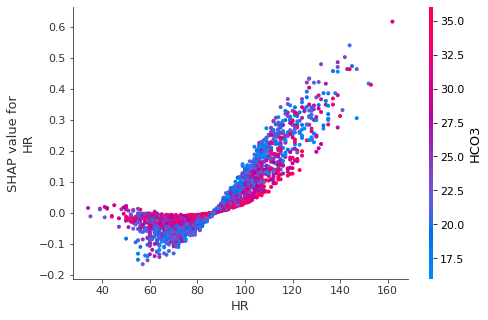

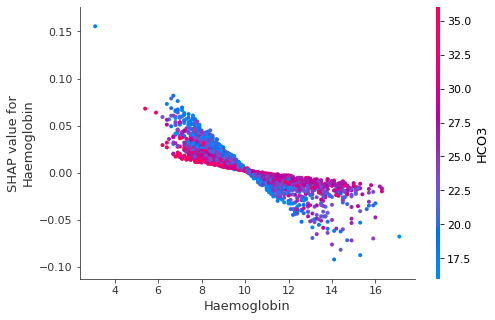

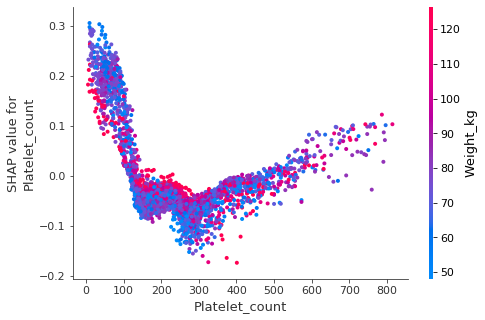

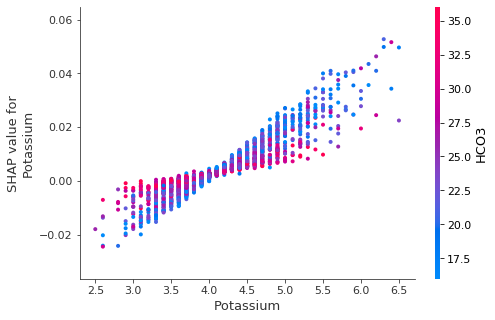

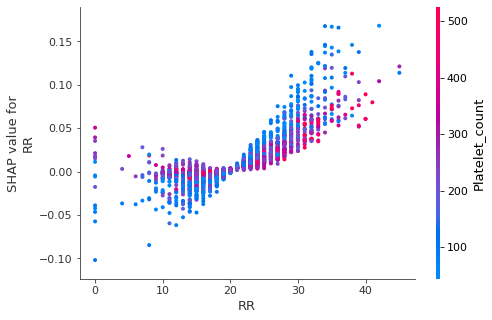

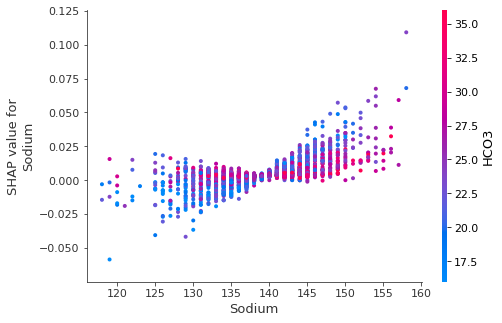

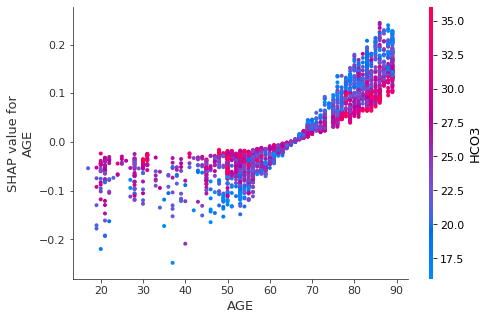

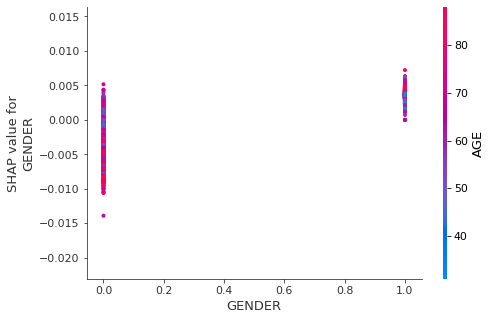

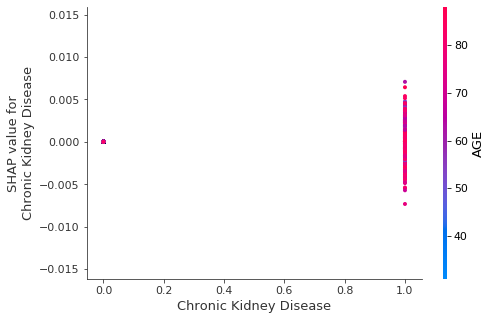

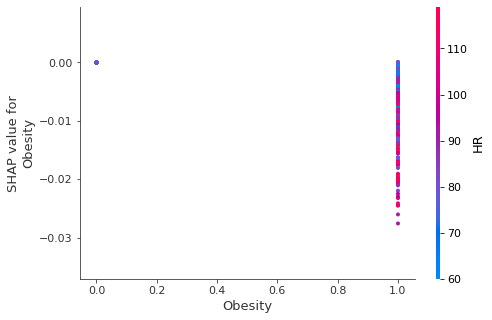

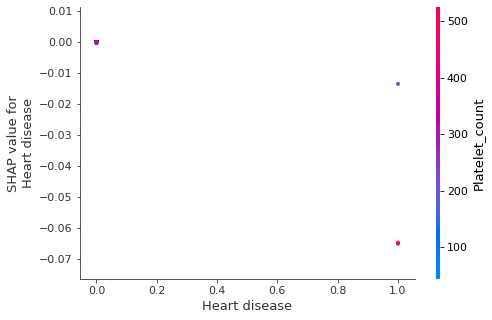

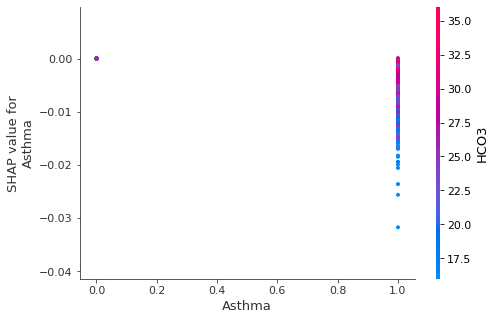

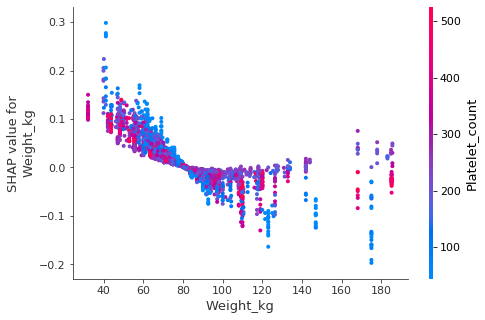

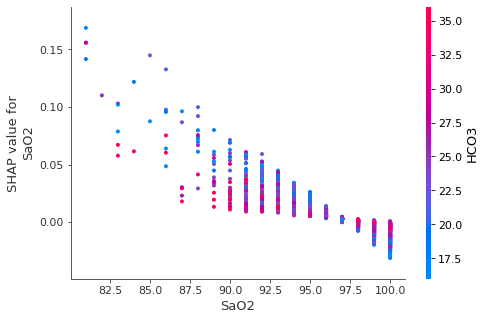

In [253]:
for feature in X_cols:
    shap.dependence_plot(feature, shap_values, features=input_data, show=False)
    savefig('Vanilla SHAP Global for ' + feature)

## Look at evolution for an entire sequence
We can use a force plot to see how the SHAP scores change through a patients stay.

However, it's important to note that the model from SHAP only uses data from a single day.

In [143]:
seq = [0] + list(map(len, lst_test))
for i in range(len(seq)):
    if i != 0:
        seq[i] += seq[i-1]

longest_sequences_index = list(reversed(np.argsort([len(x) for x in lst_test])))

In [63]:
index = longest_sequences_index[18]

sl = slice(seq[index], seq[index+1])
print(f"Sequence length: {seq[index+1] - seq[index]}")
print(f"Predicted {preds[index,0]}, Actual {Y_test[index]}")
shap.force_plot(explainer.expected_value, shap_values[sl], input_data[sl])

Sequence length: 24
Predicted 0.9961161613464355, Actual 1


In [231]:
shap.force_plot?

In [236]:
index = 8
sl = slice(index, index+1)
shap.force_plot(explainer.expected_value, shap_values[sl], input_data[sl])#, show=False, matplotlib=True)
# savefig('SHAP individual explanation')

In [65]:
index = 12
sl = slice(index, index+1)
shap.force_plot(explainer.expected_value, shap_values[sl], input_data[sl])

In [66]:
shap.force_plot(explainer.expected_value, shap_values, input_data)

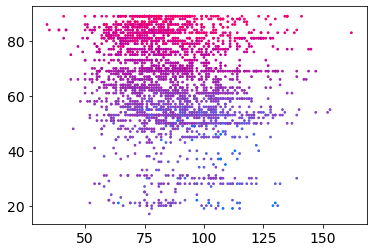

In [67]:
import matplotlib.pyplot as pl
from shap.plots import colors 

pl.scatter(input_data['HR'], input_data['AGE'], s=3,
           c=shap_values[:, X_cols.index('AGE')], cmap=colors.red_blue)

# New SHAP LSTM Design

This article highlights the problem with doing SHAP the way I have above, as does the `Model Predictions For Sequence` graph above. There should be no difference between the force plot from SHAP and the actual sequence predictions, however it is clear there is a difference.

https://towardsdatascience.com/interpreting-recurrent-neural-networks-on-multivariate-time-series-ebec0edb8f5a

The solution is to use a fundamental property of LSTMs - the hidden states. The solution still involves inputting a single time step at a time into SHAP. However, we now store the previous LSTM hidden states and pass them on to the next time step in the sequence. This will require some changes to the SHAP library.

In order to do this, I have made my model take two extra inputs for the hidden states and the model also gives two extra outputs for the hidden states.

For a reference implementation in pytorch, see https://github.com/AndreCNF/shap (https://github.com/slundberg/shap/compare/master...AndreCNF:master).


To tell SHAP how the sequences are related, we pass in an `association` array. This is a mapping from index in sequence to sequence id. In this case, it's just the HADM_ID slice in the dataframe.

In [128]:
def state_predict(X, internal_state=None):
    """
    internal_state: list of internal states. should be of the form [h, c]
    
    Returns [output, h, c]
    """
    if isinstance(X, (pd.DataFrame, pd.Series)):
        X = X.values
    X = X.reshape((-1,1,len(X_cols)))
    
    if internal_state:
        h,c = internal_state
        o, nh, nc = model_predict(X, h=h, c=c, state=True)
        return o.flatten(), nh, nc

    o, nh, nc = model_predict(X, state=True)
    return o.flatten(), nh, nc

In [129]:
input_data = df_test[X_cols]

In [64]:
state_explainer = shap.KernelExplainer(state_predict, all_data_summary)
state_shap_values = state_explainer.shap_values(input_data, association=df_test['HADM_ID'])

In [65]:
# save explanations 
pickle.dump(state_explainer, open(os.path.join(model_name, 'shap_values', 'state_explainer.pkl'), "wb"))
pickle.dump(state_shap_values, open(os.path.join(model_name, 'shap_values', 'state_shap_values.pkl'), "wb"))

In [130]:
# load explanations
state_explainer = pickle.load(open(os.path.join(model_name, 'shap_values', 'state_explainer.pkl'), "rb"))
state_shap_values = pickle.load(open(os.path.join(model_name, 'shap_values', 'state_shap_values.pkl'), "rb"))

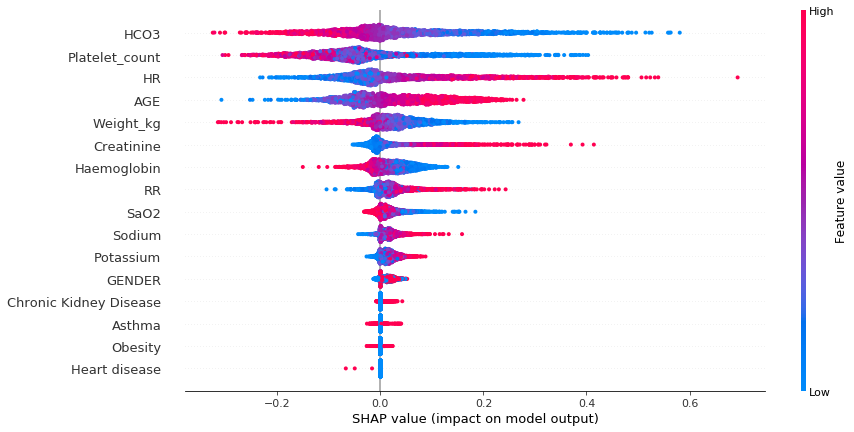

In [132]:
shap.summary_plot(state_shap_values, input_data, plot_size=figsize, show=False)
savefig('New SHAP Global')

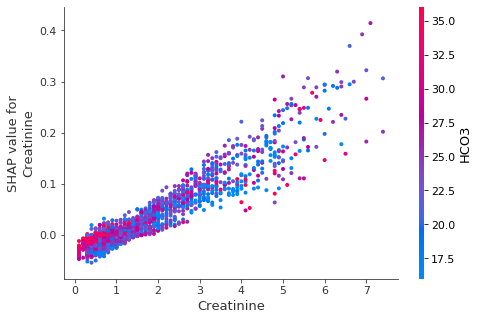

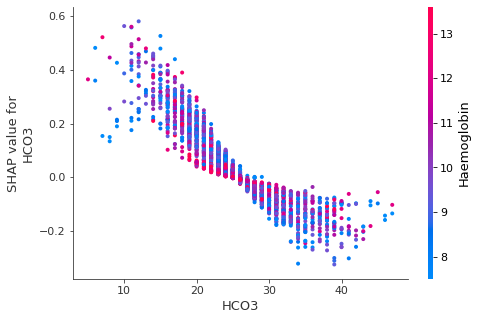

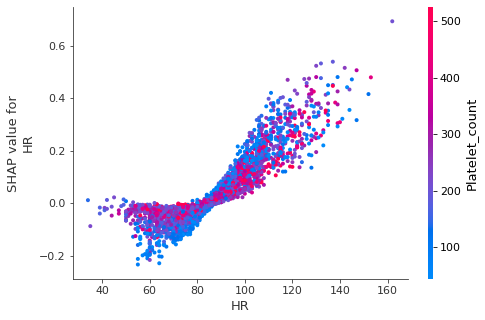

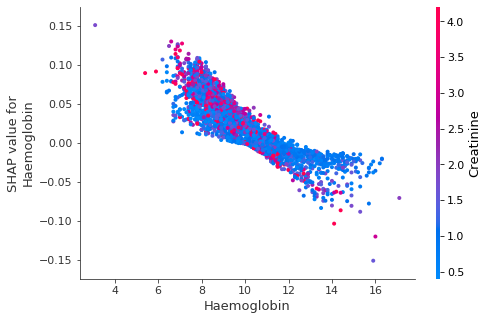

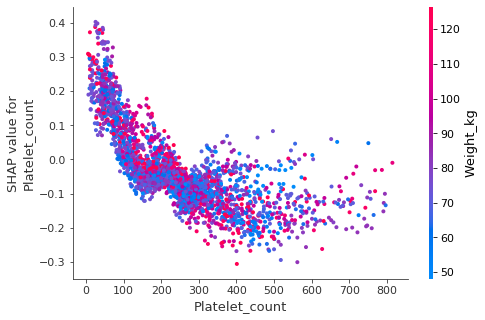

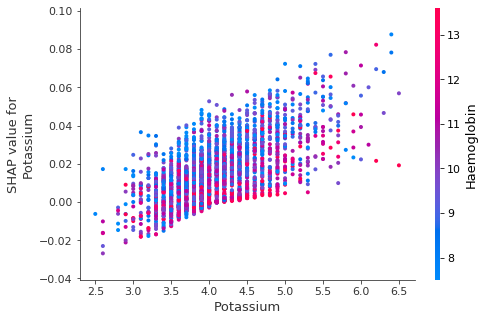

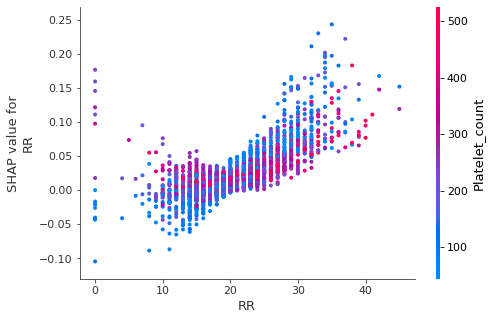

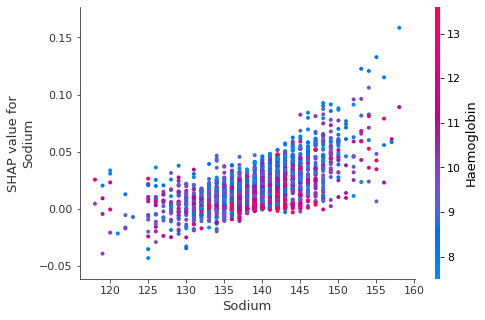

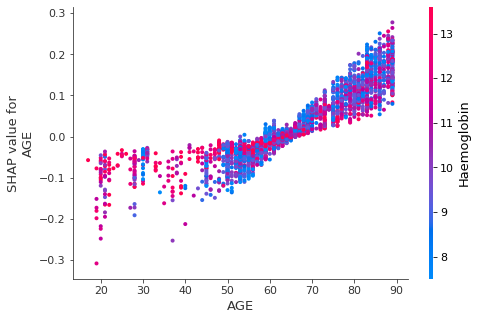

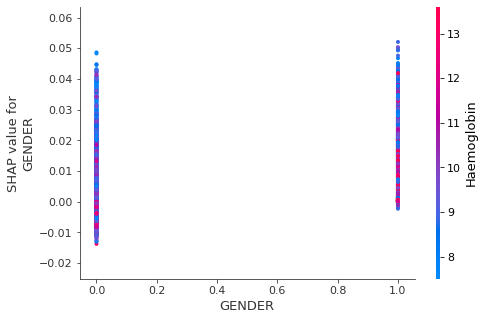

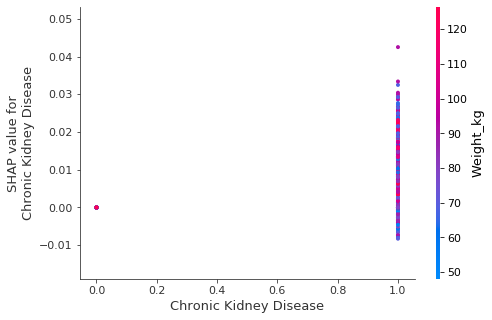

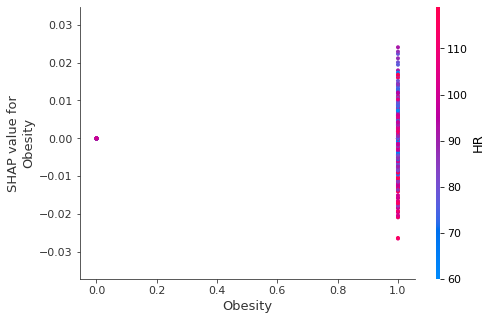

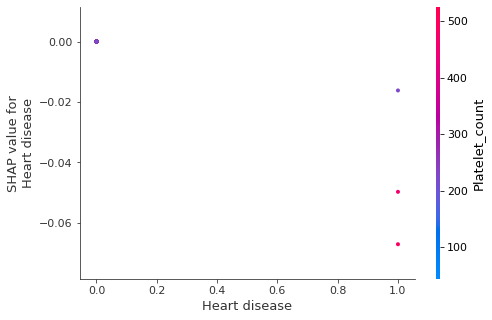

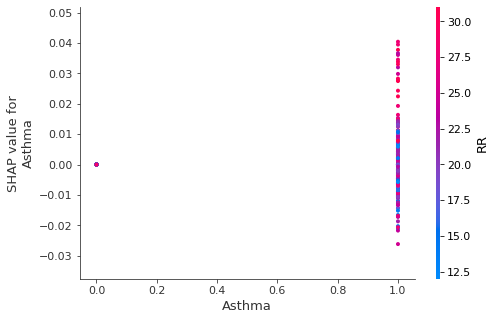

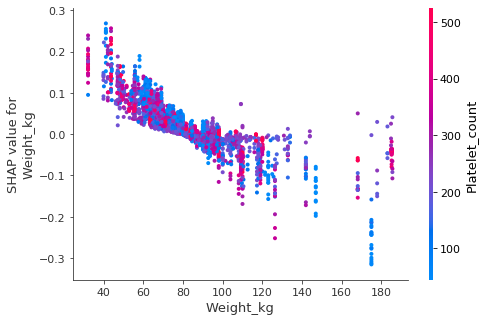

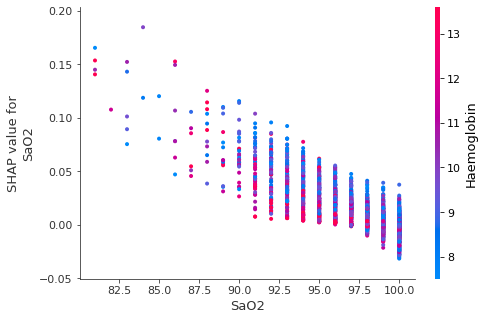

In [134]:
for feature in X_cols:
    shap.dependence_plot(feature, state_shap_values, features=input_data, show=False)
    savefig('New SHAP Global for' + feature)

In [81]:
shap.force_plot(state_explainer.expected_value, state_shap_values, input_data)

In [73]:
index = longest_sequences_index[30]

sl = slice(seq[index], seq[index+1])
print(f"Sequence length: {seq[index+1] - seq[index]}")
print(f"Predicted {preds[index,0]}, Actual {Y_test[index]}")
shap.force_plot(state_explainer.expected_value, state_shap_values[sl], input_data[sl])

Sequence length: 20
Predicted 0.9476625919342041, Actual 1


In [74]:
shap.force_plot(explainer.expected_value, shap_values[sl], input_data[sl])

### Interesting things
Notice the significantly greater mean SHAP value

In [75]:
pd.Series((state_shap_values.sum(axis=1) + state_explainer.expected_value)).describe()

count    2787.000000
mean        0.368911
std         0.313447
min         0.008972
25%         0.097687
50%         0.259928
75%         0.615882
max         0.997797
dtype: float64

In [76]:
pd.Series((shap_values.sum(axis=1) + explainer.expected_value)).describe()

count    2787.000000
mean        0.246504
std         0.253898
min         0.008490
25%         0.062802
50%         0.133563
75%         0.354717
max         0.986158
dtype: float64

In [77]:
pd.Series(((state_shap_values.sum(axis=1) + state_explainer.expected_value) > (shap_values.sum(axis=1) + explainer.expected_value))).value_counts()

True     1969
False     818
dtype: int64

We wish to see what difference the single day data makes on the models confidence throughout the stay.

We can see that the dashed lines overlap the non dashed lines

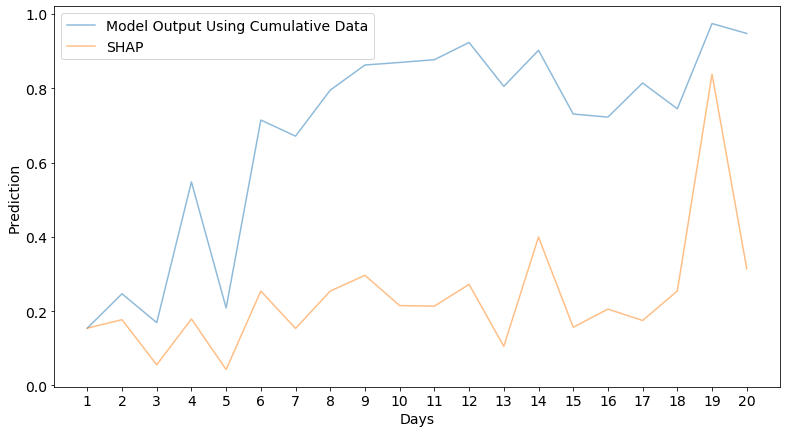

In [218]:
set_figsize()
my_arr = lst_test[index]
x = range(1,len(my_arr)+1)
sl = slice(seq[index], seq[index+1])

all_data = [my_arr[:i].reshape((1,-1,len(X_cols))) for i in x]
single_day = [my_arr[i-1:i].reshape((1,-1,len(X_cols))) for i in x]

all_data = np.array([model_predict(x) for x in all_data]).reshape(-1)
single_day = np.array([model_predict(x) for x in single_day]).reshape(-1)

sns.lineplot(x=x, y=all_data, alpha=0.5, label="Model Output Using Cumulative Data")
# sns.lineplot(x=x, y=state_shap_values[sl].sum(axis=1) + state_explainer.expected_value,
#                   alpha=0.5, label="New SHAP")
# sns.lineplot(x=x, y=single_day, alpha=0.5, label="One Day Data")
ax = sns.lineplot(x=x, y=shap_values[sl].sum(axis=1) + explainer.expected_value,
                  alpha=0.5, label="SHAP")
# ax.lines[1].set_linestyle("--")
# ax.lines[3].set_linestyle("--")
plt.legend()
# plt.title('Model Predictions For Sequence')
plt.ylabel('Prediction')
plt.xlabel('Days')
plt.xticks(x)
savefig('Vanilla SHAP local1')
plt.show()

### Do the above plot but for all sequences

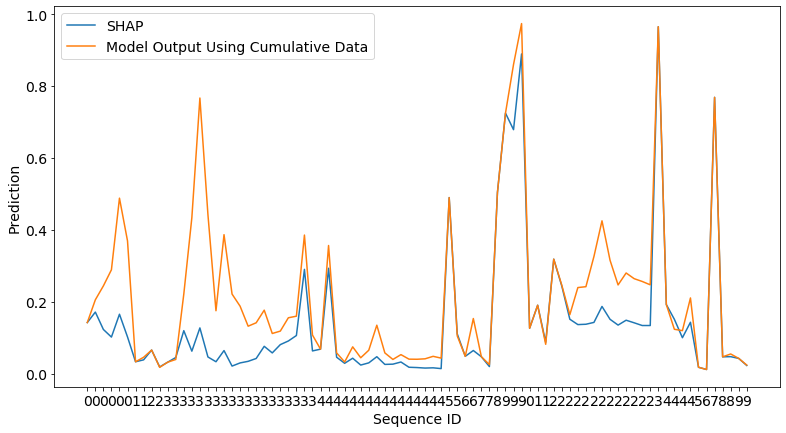

Wall time: 2.3 s


In [219]:
%%time
x = []
y1 = []
y2 = []

for i, my_arr in enumerate(lst_test[:20]):
    my_x = range(1,len(my_arr)+1)
    sl = slice(seq[i], seq[i+1])

    all_data = [my_arr[:i].reshape((1,-1,len(X_cols))) for i in my_x]
    
    all_data = np.array([model_predict(x) for x in all_data]).reshape(-1)

    x += [str(i % 10)] * len(my_arr)
    y1 += list(all_data)
    y2 += list(shap_values[sl].sum(axis=1) + explainer.expected_value)
    
set_figsize()
plt.plot(range(len(y1)), y2, label="SHAP")
plt.plot(range(len(y1)), y1, label="Model Output Using Cumulative Data")
plt.xticks(range(len(y1)), x)
plt.legend()
plt.ylabel('Prediction')
plt.xlabel('Sequence ID')
savefig('Vanilla SHAP local2')
plt.show()

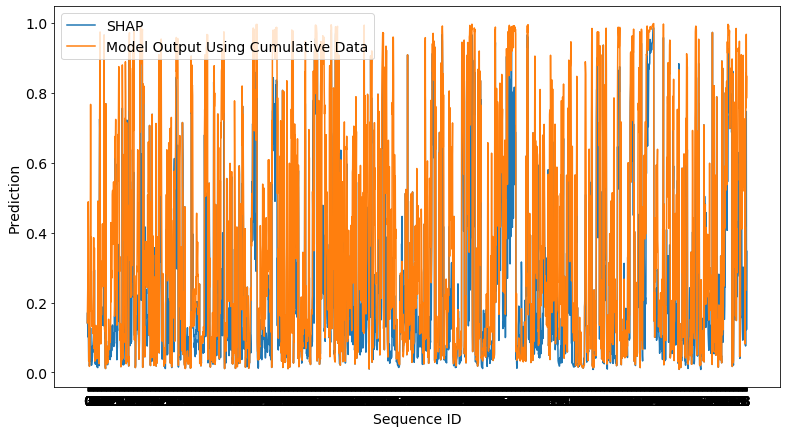

Wall time: 1min 15s


In [220]:
%%time
x = []
y1 = []
y2 = []

for i, my_arr in enumerate(lst_test):
    my_x = range(1,len(my_arr)+1)
    sl = slice(seq[i], seq[i+1])

    all_data = [my_arr[:i].reshape((1,-1,len(X_cols))) for i in my_x]
    
    all_data = np.array([model_predict(x) for x in all_data]).reshape(-1)

    x += [str(i % 10)] * len(my_arr)
    y1 += list(all_data)
    y2 += list(shap_values[sl].sum(axis=1) + explainer.expected_value)
    
set_figsize()
plt.plot(range(len(y1)), y2, label="SHAP")
plt.plot(range(len(y1)), y1, label="Model Output Using Cumulative Data")
plt.xticks(range(len(y1)), x)
plt.legend()
plt.ylabel('Prediction')
plt.xlabel('Sequence ID')
savefig('Vanilla SHAP local2')
plt.show()